In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine	
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit_algorithms.optimizers import SPSA

# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = AerSimulator()

In [3]:
hamiltonian = SparsePauliOp.from_list(
    [('XX', 1), ('YY', 1), ('ZI', 1)]
)

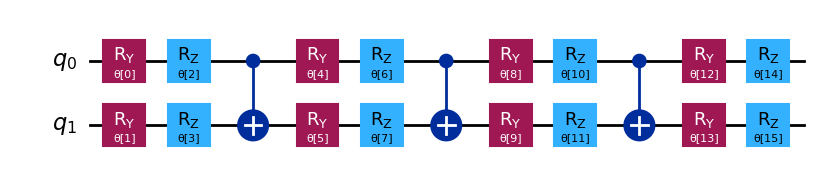

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [5]:
num_params = ansatz.num_parameters
num_params

16

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

ansatz_isa = pm.run(ansatz)

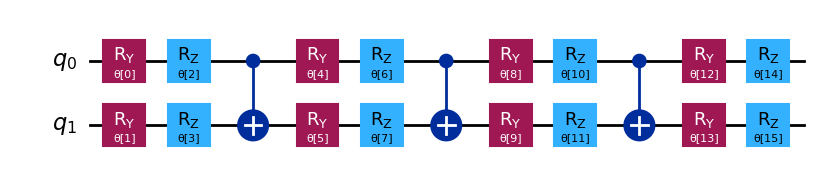

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [9]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [10]:
def cost_func(params, ansatz, hamiltonian, estimator):
	"""Return estimate of energy from estimator

	Parameters:
		params (ndarray): Array of ansatz parameters
		ansatz (QuantumCircuit): Parameterized ansatz circuit
		hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
		estimator (EstimatorV2): Estimator primitive instance
		cost_history_dict: Dictionary for storing intermediate results

	Returns:
		float: Energy estimate
	"""
	pub = (ansatz, [hamiltonian], [params])
	result = estimator.run(pubs=[pub]).result()
	energy = result[0].data.evs[0]
	
	cost_history_dict["iters"] += 1
	cost_history_dict["prev_vector"] = params
	cost_history_dict["cost_history"].append(energy)
	print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

	return energy

In [11]:
x0 = 2 * np.pi * np.random.random(num_params)

In [12]:
x0

array([0.14052488, 4.21105203, 0.47929302, 1.23382051, 0.25503488,
       3.11002839, 1.1851989 , 4.98194545, 0.42418691, 4.03366573,
       1.59995807, 4.14640767, 5.99605517, 1.86808443, 2.72247065,
       2.87250952])

In [13]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
    )

Iters. done: 1 [Current cost: 0.9448000000000001]
Iters. done: 2 [Current cost: 0.9962]
Iters. done: 3 [Current cost: 1.071]
Iters. done: 4 [Current cost: 0.8839999999999999]
Iters. done: 5 [Current cost: 0.6689999999999999]
Iters. done: 6 [Current cost: 1.1019999999999999]
Iters. done: 7 [Current cost: 0.8576]
Iters. done: 8 [Current cost: 0.6716]
Iters. done: 9 [Current cost: 0.9136]
Iters. done: 10 [Current cost: 0.6202000000000001]
Iters. done: 11 [Current cost: -0.5713999999999999]
Iters. done: 12 [Current cost: -0.8962]
Iters. done: 13 [Current cost: -0.4878]
Iters. done: 14 [Current cost: -1.5408]
Iters. done: 15 [Current cost: -0.36279999999999996]
Iters. done: 16 [Current cost: -0.9488]
Iters. done: 17 [Current cost: -1.2714]
Iters. done: 18 [Current cost: -1.307]
Iters. done: 19 [Current cost: -1.0402]
Iters. done: 20 [Current cost: -1.5308000000000002]
Iters. done: 21 [Current cost: -0.9886]
Iters. done: 22 [Current cost: -0.9082]
Iters. done: 23 [Current cost: -1.4809999999

In [14]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.219
       x: [ 3.528e-01  4.707e+00 ...  2.098e+00  2.892e+00]
    nfev: 156
   maxcv: 0.0

In [15]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [16]:
cost_history_dict["iters"] == res.nfev

True

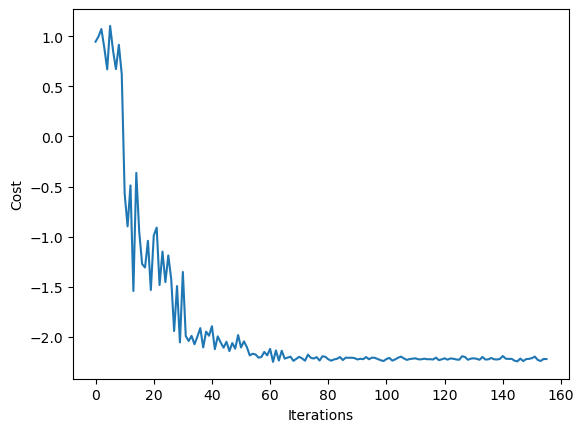

In [17]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [18]:
from qiskit_algorithms import NumPyMinimumEigensolver

exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(hamiltonian)

In [19]:
print('Optimized ground state energy:', res.fun)
print('Exact ground state energy:', exact_result.eigenvalue.real)
print('Energy Difference:', abs(exact_result.eigenvalue.real - res.fun))

Optimized ground state energy: -2.219
Exact ground state energy: -2.236067977499788
Energy Difference: 0.017067977499788167
